In [1]:
from os import path

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import plotly.graph_objects as go

from synthetic import *
from plotter import *
from IPython.display import Video

np.random.seed(0)

## Spatio-Temporal Self-Correcting Process

$$
\lambda^*(s, t) = \mu \exp\left(g_0(s)\beta t - \sum_{t_i < t} \alpha g_2(s, s_i)\right)
$$

At time 0, $\lambda^*(s, t) = \mu$ for any $s$ in bounded region $\mathcal S$. $\mu$ decides the initial intensity magnitude. 

$\beta$ decides the intensity increase speed. A larger $\beta$ leads to more events. 

$g_0(s)$ decides the intensity increase distribution. $g_0$ with smaller variance leads to more events at the center of $\mathcal S$.

$\alpha$ decides the extent of intensity decrease after each event. A larger $\alpha$ leads to fewer events.

$g_2(s, s_i)$ decides the intensity decrease distribution by event $s_i$. $g_2$ with small variance means the occurrence of an event would only influence its close neighborhood.

In our implementation, the $\mathcal S$ is fixed to $[[0\sim1], [0\sim1]]$.

In our implementation, $g_2(s, s_i)$ is assumed to be a bivariate Gaussian distribution with $\mu = s_i$ and $\Sigma = \dfrac{\Sigma_c}{\gamma\|s-s_\mu\|_2^2 + 1} $. 

$\Sigma_c$ is a constant covariance matrix to be specified, and is the covariance matrix for $g_2(s, s_\mu)$. Such design means that when an event is further from the center, its influence region is more limited.

---

### Case 0: Corner Emphasis

A large $g_0(s)$ variance paired with a slightly smaller $g_2(s, s_i)$ variance. The intensity at the corner will increases fairly fast as $t$ increase, and the event near the center can hardly reduce the intensity at the corner. The result is in most of the time, the intensity concentrates on the corners. Most events are near the corner; Almost all events are near the edge. 

In [2]:
stscp0 = STSCPDataset(g0_cov = np.array([[1, 0],
                                         [0, 1]]),
                      g2_cov = np.array([[.85, 0],
                                         [0, .85]]),
                      alpha = .2, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101,
                      max_history=100, dist_only=False)

#stscp0.generate(t_start=0, t_end=10000, verbose=True)
#stscp0.save('data/stscp0.data')
stscp0.load('data/stscp0.data', t_start=0, t_end=10000)

10201it [00:07, 1337.31it/s]


In [ ]:
plot_lambst_interactive(*stscp0.get_lamb_st(101, 101, 51, 900, 1000), heatmap=True)
#plot_lambst_static(*stscp0.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
#                   fps=12, fn='video/stscp0.mp4')
#Video('video/stscp0.mp4')

### Case 1: Balanced 

Carefully chosen $g_0(s)$ and $g_2(s, s_i)$ such that most of the time the intensities at the corner, on the edge and near the center are roughly similar. The resulting $\lambda_{st}$ animation is the most interesting as there is no huge difference between intensities at different parts of the space.

In [96]:
stscp1 = STSCPDataset(g0_cov = np.array([[.4, 0],
                                         [0, .4]]),
                      g2_cov = np.array([[.3, 0],
                                         [0, .3]]),
                      alpha = .3, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101, lamb_max = 4, 
                      max_history=100, dist_only=False)

#stscp1.generate(t_start=0, t_end=10000, verbose=True)
#stscp1.save('data/stscp1.data')
stscp1.load('data/stscp1.data', t_start=0, t_end=10000)

10201it [00:07, 1368.35it/s]


In [ ]:
plot_lambst_interactive(*stscp1.get_lamb_st(101, 101, 51, 900, 1000), heatmap=True)
#plot_lambst_interactive(*stscp1.get_lamb_st_(9900, 10000))
#plot_lambst_static(*stscp1.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
#                   fps=12, fn='video/stscp1.mp4')
#Video('video/stscp1.mp4')

### Case 2: Center Emphasis

A small $g_0(s)$ variance paired with a smaller $g_2(s, s_i)$ variance. The intensity at the center grows so fast such that most of the events are near the center to control such growth.

In [6]:
stscp2 = STSCPDataset(g0_cov = np.array([[.25, 0],
                                         [0, .25]]),
                      g2_cov = np.array([[.2, 0],
                                         [0, .2]]),
                      alpha = .4, beta = .2, mu = 1, gamma = 0,
                      x_num = 101, y_num = 101,
                      max_history=100, dist_only=False)

#stscp2.generate(t_start=0, t_end=10000, verbose=True)
#stscp2.save('data/stscp2.data')
stscp2.load('data/stscp2.data', t_start=0, t_end=10000)

10201it [00:04, 2349.80it/s]


100%|██████████| 1000/1000 [00:17<00:00, 58.68it/s]


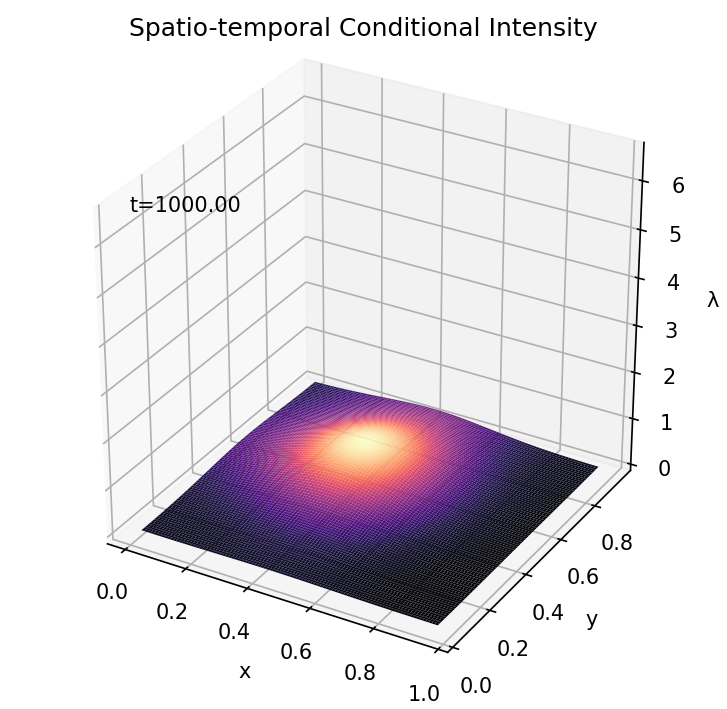

In [7]:
#plot_lambst_interactive(*stscp2.get_lamb_st_(9900, 10000))
plot_lambst_static(*stscp2.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/stscp2.mp4')
Video('video/stscp2.mp4')

## Spatio-Temporal Hawkes Process

$$
\lambda^*(s, t) := \mu g_0(s) + \sum_{i=0}^n g_1(t, t_i) g_2(s, s_i) \\
g_1(t, t_i) := \alpha e^{-\beta (t-t_i)}
$$

With the kernel functions defined according to the Omori law, the model could be called the epidemic-type aftershock sequence (ETAS) model. 

The process can be viewed as a summation of a stationary (base) Poisson process with intensity $\mu g_0 (s)$, and every historical event $(t_i, s_i)$'s decaying Poisson processes with intensity $g_1(t, t_i) g_2(s, s_i)$.

$\alpha$ decides the extent of intensity increase after each event. A larger $\alpha$ leads to more events.

$\beta$ decides the intensity decrease speed. A larger $\beta$ leads to fewer events. 

$g_0$ with smaller variance leads to more clustered base event. $g_2$ with smaller variance leads to the excited events close to the exciting event. It is notewothy when the variance is too small, the excitation would be too intense and may causing intensity explosion. Since in SHTP, more events results in higher intensity and therefore more events; whereas in STSCP, more events results in lower intensity.

---

### Case 0: Unimodal Excitation

A fairly small $g_0$ variance and a relatively small $g_2$ variance result in most base events occur near the center, and their influence are mostly local—the excitation is also near center. The resulting intensity is mostly unimodal throughout the time. 

In [8]:
sthp0 = STHPDataset(s_mu  = np.array([0, 0]), 
                    g0_cov = np.array([[.2, 0],
                                       [0, .2]]),
                    g2_cov = np.array([[.5, 0],
                                       [0, .5]]),
                    alpha = .5, beta = 1, mu = .2,
                    dist_only=False)
#sthp0.generate(t_start=0, t_end=10000, verbose=True)
#sthp0.save('data/sthp0.data')
sthp0.load('data/sthp0.data', t_start=0, t_end=10000)

100%|██████████| 1001/1001 [17:01<00:00,  1.02s/it]


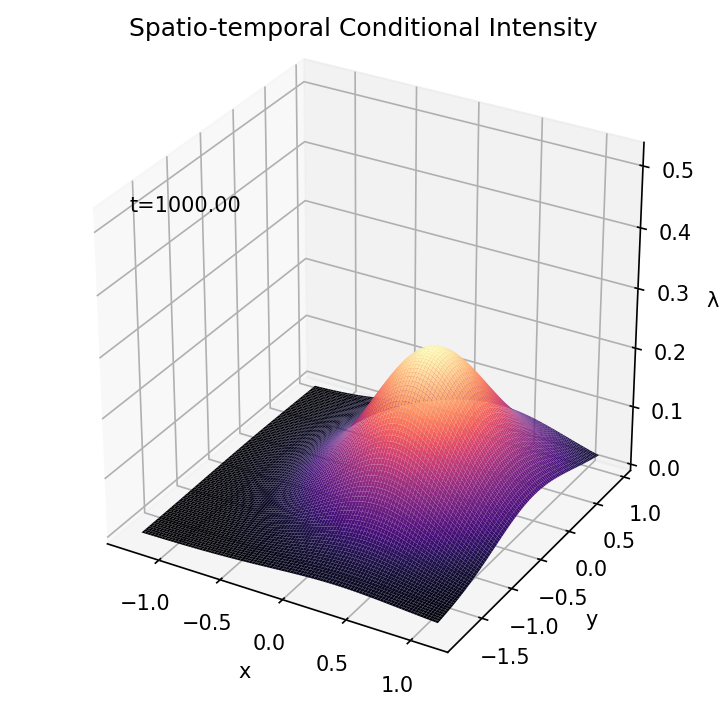

In [9]:
#plot_lambst_interactive(*sthp0.get_lamb_st(x_num=51, y_num=51, t_num=101, t_start=0, t_end=50))
plot_lambst_static(*sthp0.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/sthp0.mp4')
Video('video/sthp0.mp4')

### Case 1: Multi-modal Excitation

A large $g_0$ variance, a small $g_2$ variance, a low base intensity $\mu$, and a slower excitation decrease speed $\beta$, results in few, widely distributed base events that produce intensive local excitation. The resulting intensity is multi-modal and earthquake-like.

In [2]:
sthp1 = STHPDataset(s_mu  = np.array( [0, 0]), 
                    g0_cov = np.array([[5, 0],
                                       [0, 5]]),
                    g2_cov = np.array([[.1, 0],
                                       [0, .1]]),
                    alpha = .5, beta = .6, mu = .15,
                    dist_only=False)
#sthp1.generate(t_start=0, t_end=10000, verbose=True)
#sthp1.save('data/sthp1.data')
sthp1.load('data/sthp1.data', t_start=0, t_end=10000)

In [25]:
lambs, x_range, y_range, t_range = sthp1.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000)

100%|██████████| 1001/1001 [43:37<00:00,  2.61s/it] 


In [ ]:
stscp_points = stscp1.his_t[np.logical_and(stscp1.his_t >= 910, stscp1.his_t < 915)]
ax1.scatter(stscp_points, np.ones(stscp_points.shape),  label='STSCP events')

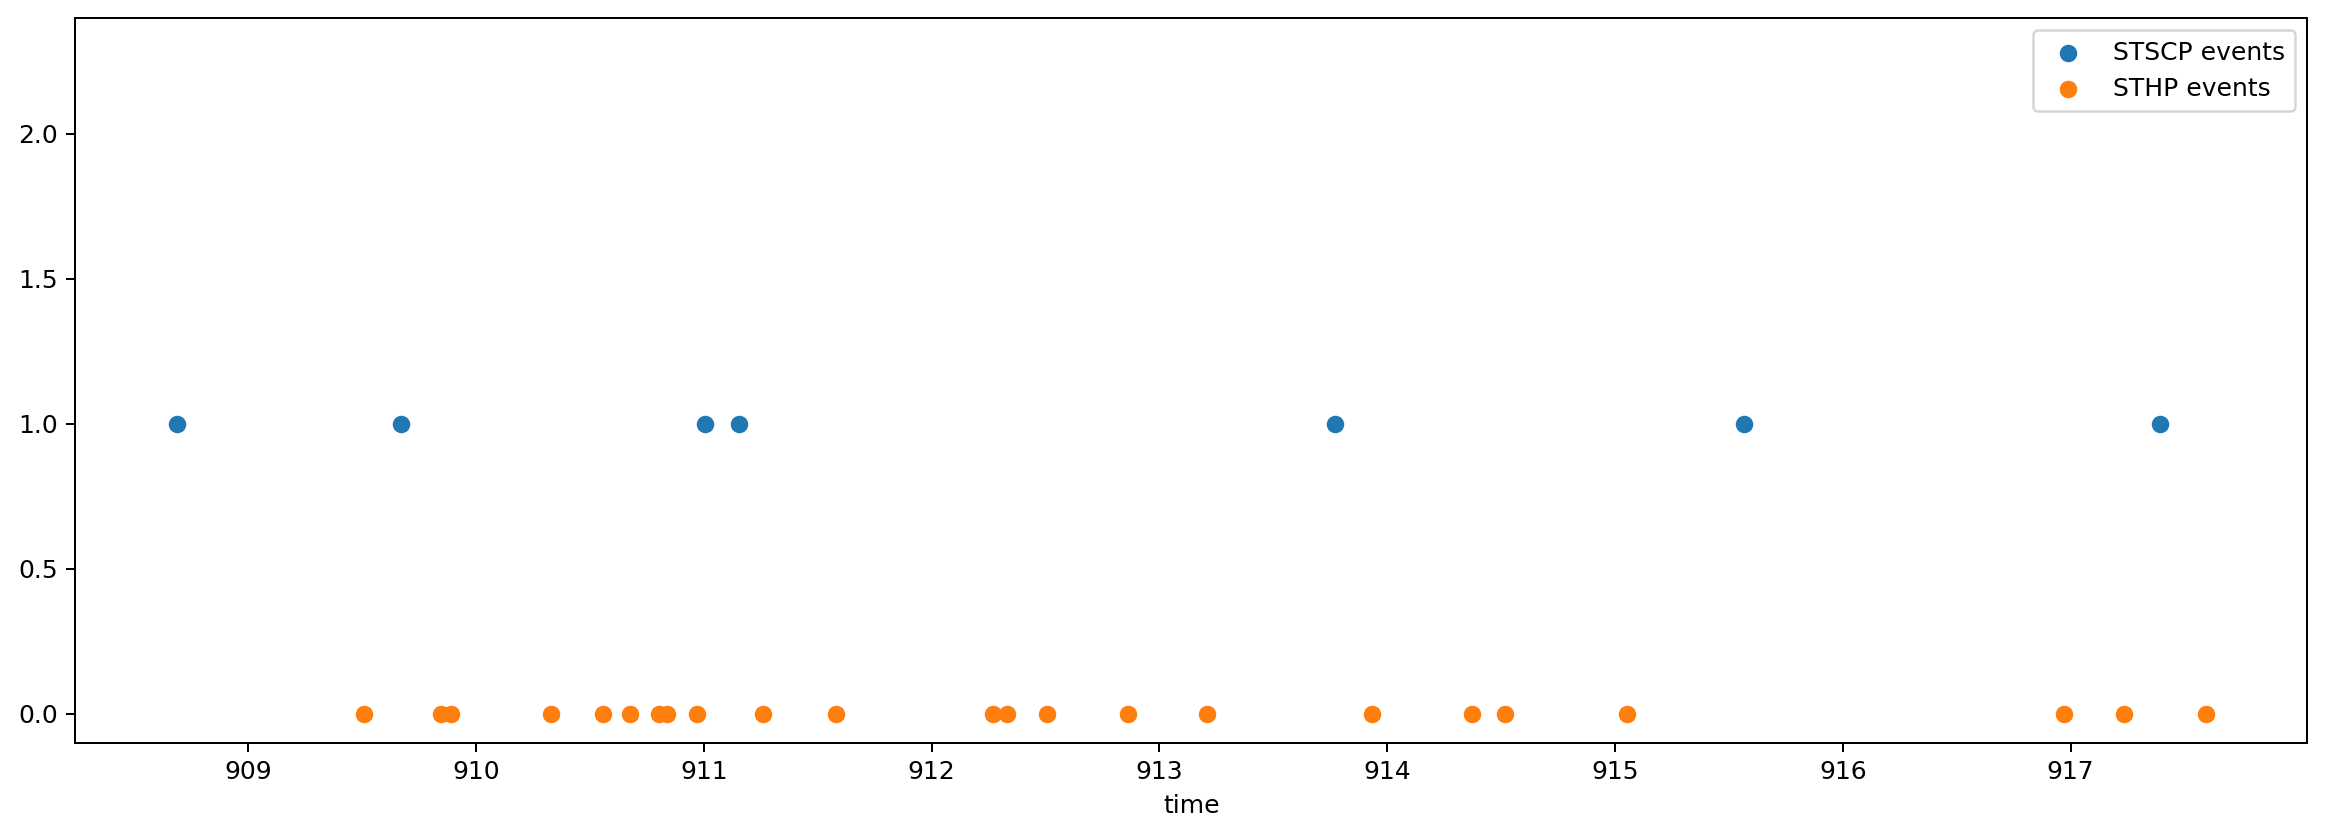

In [99]:
width, _ = plt.figaspect(.1)
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(width, width/3), dpi=180)
ax1.set_xlabel('time')
ax1.set_ylim((-0.1, 2.4))
ax1.set_xticks(np.arange(908, 918, 1))

stscp_points = stscp1.his_t[np.logical_and(stscp1.his_t >= 908, stscp1.his_t < 918)]
ax1.scatter(stscp_points, np.ones(stscp_points.shape),  label='STSCP events')

sthp_points = sthp1.his_t[np.logical_and(sthp1.his_t >= 908, sthp1.his_t < 918)]
ax1.scatter(sthp_points, np.zeros(sthp_points.shape), label='STHP events')

ax1.legend()

In [124]:
lambs, x_range, y_range, t_range = stscp1.get_lamb_st(x_num=101, y_num=101, t_num=101, t_start=900, t_end=1000)

100%|██████████| 100/100 [00:07<00:00, 14.12it/s]


In [125]:
t_range[8]

908.0

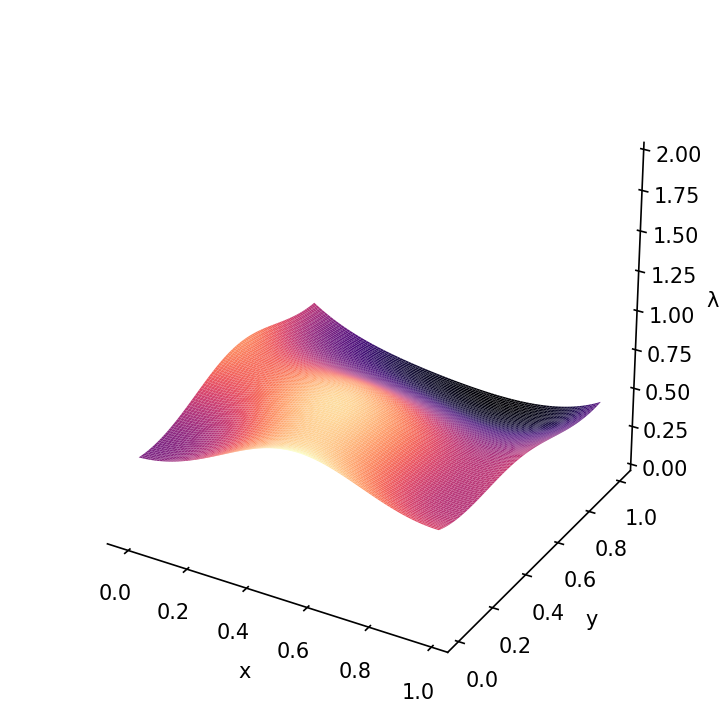

In [140]:
grid_x, grid_y = np.meshgrid(x_range, y_range)

fig = plt.figure(figsize=(6,6), dpi=150)
ax = fig.add_subplot(111, projection='3d', xlabel='x', ylabel='y', zlabel='λ', zlim=(0, 2))

# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

#ax.axis('off')
ax.plot_surface(grid_x, grid_y, lambs[18], rstride=1, cstride=1, cmap="magma")

In [137]:
#plot_lambst_interactive(*sthp1.get_lamb_st(x_num=51, y_num=51, t_num=10, t_start=910, t_end=920))
#plot_lambst_static(*sthp1.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
#                   fps=12, fn='video/sthp1.mp4')
#Video('video/sthp1.mp4')

### Case 2: Less Excitation

A smaller excitation coefficient $\alpha$ and a fast excitation decrease speed $\beta$ produce a small and transient historical influence. The events in such case are less contributing to the occurence of events afterwards.

In [12]:
sthp2 = STHPDataset(s_mu  = np.array( [0, 0]), 
                    g0_cov = np.array([[1, 0],
                                       [0, 1]]),
                    g2_cov = np.array([[.1, 0],
                                       [0, .1]]),
                    alpha = .3, beta = 2, mu = 1,
                    dist_only=False)
#sthp2.generate(t_start=0, t_end=10000, verbose=True)
#sthp2.save('data/sthp2.data')
sthp2.load('data/sthp2.data', t_start=0, t_end=10000)

100%|██████████| 1001/1001 [24:29<00:00,  1.47s/it]


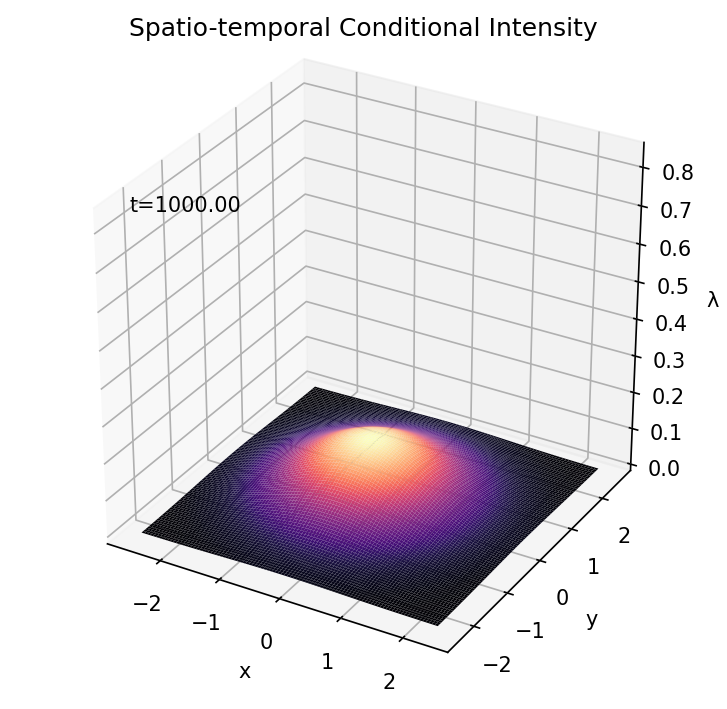

In [13]:
#plot_lambst_interactive(*sthp2.get_lamb_st(x_num=51, y_num=51, t_num=101, t_start=0, t_end=100))
plot_lambst_static(*sthp2.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/sthp2.mp4')
Video('video/sthp2.mp4')

## Learning Spatio-Temporal Hawkes Process

In [14]:
model = STHPLearner()
model.train(sthp2.his_s, sthp2.his_t)

/Users/kevinzhou/Github/deep_point_process/src/zihao/synthetic.py:570: RuntimeWarning: invalid value encountered in sqrt
  g0_sidc = 1/np.sqrt(np.linalg.det(g0_cov))
/Users/kevinzhou/Github/deep_point_process/src/zihao/synthetic.py:572: RuntimeWarning: invalid value encountered in sqrt
  g2_sidc = 1/np.sqrt(np.linalg.det(g2_cov))
/Users/kevinzhou/Github/deep_point_process/src/zihao/synthetic.py:73: RuntimeWarning: overflow encountered in exp
  np.exp(-np.einsum('ij,ij->i', delta_s.dot(s_inv_cov), delta_s)/2)
/Users/kevinzhou/Github/deep_point_process/src/zihao/synthetic.py:583: RuntimeWarning: divide by zero encountered in log
  term_1 -= np.log(lamb)


     fun: array([42071.72112288])
     jac: array([ 0.00488281,  0.0078125 , -0.00390625, -0.01269531,  0.64355469,
        0.00439453, -0.00683594, -0.02246094,  0.03662109])
 message: 'Optimization terminated successfully'
    nfev: 564
     nit: 51
    njev: 51
  status: 0
 success: True
       x: array([2.92887934e-01, 1.96890419e+00, 9.95552074e-01, 9.95125197e-01,
       1.63101388e-20, 1.00189398e+00, 1.03051320e-01, 2.31037159e-03,
       9.93672866e-02])


In [15]:
predict_s, predict_t = model.test(sthp2.his_s, sthp2.his_t, 100)
pl = TrajectoryPlotter() 
pl.add_trace(sthp2.his_s[100:500, 0],  sthp2.his_s[100:500, 1],  sthp2.his_t[100:500], "actual", "blue")
pl.add_trace(predict_s[:400, 0], predict_s[:400, 1], predict_t[:400], "predicted", "red")
pl.show()

100%|██████████| 11593/11593 [01:43<00:00, 111.83it/s]


## Discrete-Event Brownian Motion

$$
\lambda^*(t) = \mu + \alpha \exp(-\beta(t-t_n)) \\ 
\lambda^*(s, t) = g_2 (s, s_n) \lambda^*(t)
$$

$(t_n, s_n)$ is the last event before $t$. It is obvious that the intensity between the successive arrivals are independently and identically distributed (relative to the time and spatial location of the last event), and is therefore a spatio-temporal extension of the renewal process. 

It can be seen as a two-dimentional Brownian Motion Process ($B_{t+u} -  B_t \sim \mathcal N([0, 0], \Sigma)$) being observed at the time of the discrete point sampled from a renewal process $\lambda^*(t)$. Different from $\beta$ in STHP, $\beta$ in DEBM could be negative, since here the increasing intensity would be finally reset by a new event.

The advantage of having such a synthetic dataset is to test whether a model can correctly capture the current influence, not just the historical influence.

---

### Case 0: Decreasing Intensity

$\beta > 0$, so the intensity is decreasing until next event takes place. 

In [16]:
debm0 = DEBMDataset(s_mu  = np.array( [0, 0]),
                    g2_cov = np.array([[.5, 0],
                                       [0, .5]]),
                    alpha = 1, beta = .5, mu = .7,
                    dist_only=False)
#debm0.generate(t_start=0, t_end=10000, verbose=True)
#debm0.save('data/debm0.data')
debm0.load('data/debm0.data', t_start=0, t_end=10000)

100%|██████████| 1001/1001 [21:07<00:00,  1.27s/it]


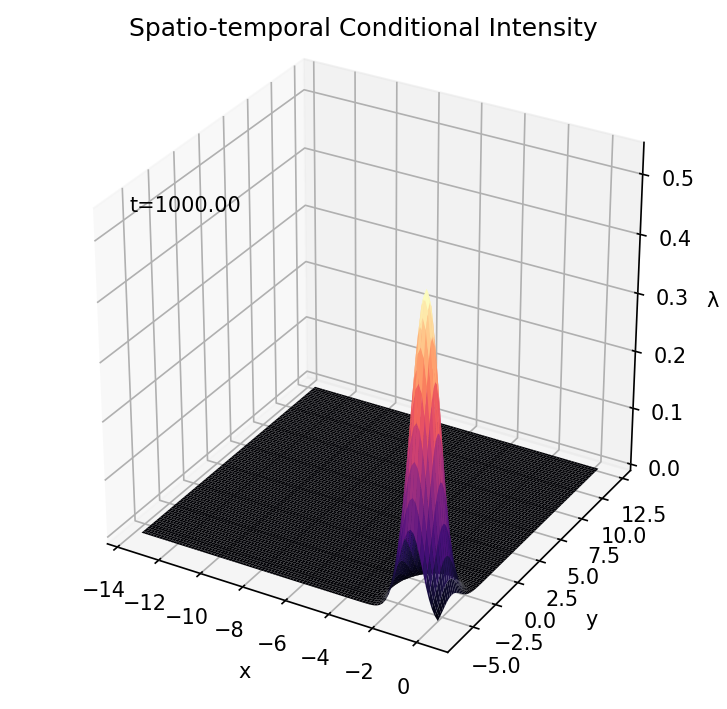

In [17]:
#plot_lambst_interactive(*debm0.get_lamb_st(x_num=51, y_num=51, t_num=101, t_start=0, t_end=50))
plot_lambst_static(*debm0.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/debm0.mp4')
Video('video/debm0.mp4')

### Case 1: Increasing Intensity

$\beta < 0$, so the intensity is increasing until next event takes place.

In [18]:
debm1 = DEBMDataset(s_mu  = np.array( [0, 0]),
                    g2_cov = np.array([[.5, 0],
                                       [0, .5]]),
                    alpha = 1, beta = -.5, mu = .7,
                    dist_only=False)
#debm1.generate(t_start=0, t_end=10000, verbose=True)
#debm1.save('data/debm1.data')
debm1.load('data/debm1.data', t_start=0, t_end=10000)

100%|██████████| 1001/1001 [25:22<00:00,  1.52s/it]


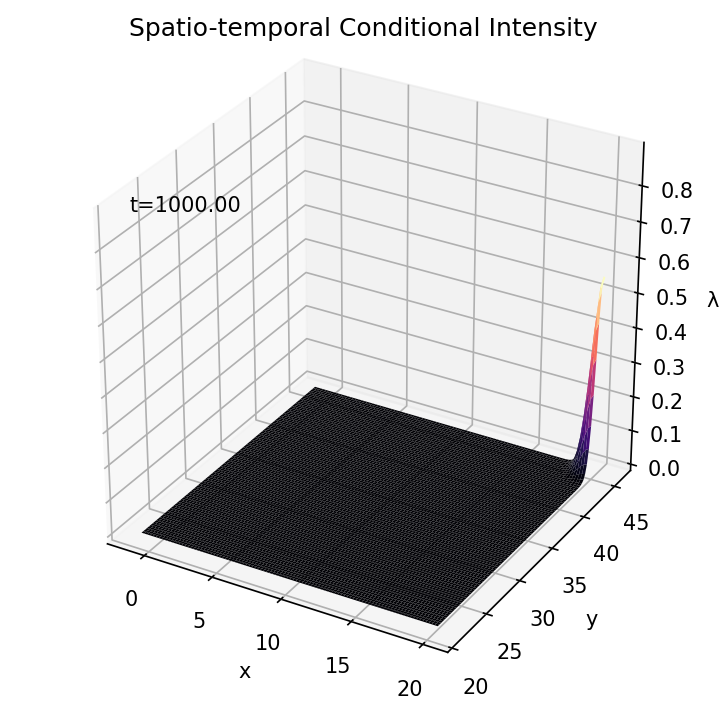

In [19]:
#plot_lambst_interactive(*debm1.get_lamb_st(x_num=51, y_num=51, t_num=101, t_start=0, t_end=50))
plot_lambst_static(*debm1.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/debm1.mp4')
Video('video/debm1.mp4')

### Case 2: Stationary Intensity

When $\beta = 0$ or $\alpha = 0$, $\lambda^*(t)$ always evaluates to a constant. If the mark is disregarded, event-time is a stationary Poisson process.

In [20]:
debm2 = DEBMDataset(s_mu  = np.array( [0, 0]),
                    g2_cov = np.array([[.5, 0],
                                       [0, .5]]),
                    alpha = 0, beta = 0, mu = .7,
                    dist_only=False)
#debm2.generate(t_start=0, t_end=10000, verbose=True)
#debm2.save('data/debm2.data')
debm2.load('data/debm2.data', t_start=0, t_end=10000)

100%|██████████| 1001/1001 [13:05<00:00,  1.27it/s]


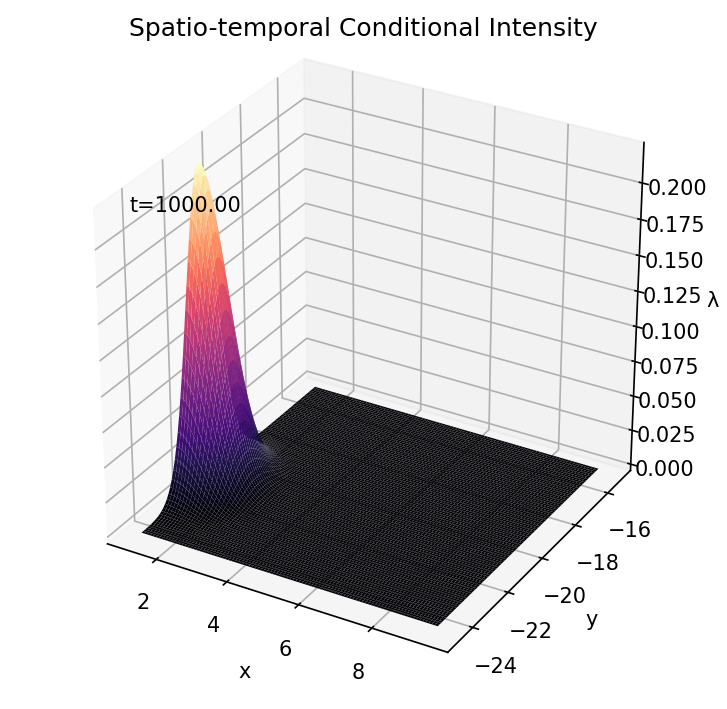

In [21]:
#plot_lambst_interactive(*debm2.get_lamb_st(x_num=51, y_num=51, t_num=101, t_start=0, t_end=50))
plot_lambst_static(*debm2.get_lamb_st(x_num=101, y_num=101, t_num=1001, t_start=900, t_end=1000), 
                   fps=12, fn='video/debm2.mp4')
Video('video/debm2.mp4')